### Regularizing the Greedy Methods
So far, we have been investigating methods that aim to minimize the mean squared error on the training data. However, this implies that we heavily overfit on the training data, and hence, we get that the matrix performs well on this data, but poorly on some other data that has been generated in the exact same way.

Therefore, we should verify MSE on another independent training set.

How to regularize:
- During the computations.
    - Break when all coefficients are below a certain *tolerance*. Again, we can have multiple kinds of tolerances.
        - Largest correlation with residual. Easy to compute.
        - Two-norm of the current residual. Difficult, do not know the minimum before hand.
        - Visual inspection. 
        - Coefficient size. Again, coefficient is not very good.
- After the computations.
    - Thresholding coefficient values. We can threshold based on several metrics.
        - Correlation with residual when we exclude the edge.
        - Two norm after excluding the edge.
        - Simply set all edges with an absolute value smaller than $\texttt{tol}$ to be equal to zero.
    - Bootstrapping.
        - Resample, based on difference in:
            - Two norm. 
            - Difference between inferred adjacency matrices.
    - Cross Validation.
    
        
More formal. A greedy method generally yields a matrix $W$. However, the nine greedy methods yield a *set* of matrices $\mathcal{W}= \{W_0, W_1, \ldots, W_K\}$. The index indicates the number of edges, and also the importance of the edges. At each iteration $k$, we add an edge to the matrix $W_{k-1}$, which yields the matrix $W_k$. The edge that is added corresponds to the edge that is the most important out of all possible edges. Naturally, on the training data, we have the ordering 

$$\texttt{MSE}(W_{k - 1}) \leq \texttt{MSE}(W_k)\ \forall k = 1, \ldots, K.$$

How unimportant an edge is, it will never decrease the mean squared error on the training data, and almost always increase it. However, we also want our greedy method to *generalize*, in other words, achieve a low MSE on similarly generated data. This means that we must not *overfit* on the data.

So, we are looking for a regularizing method such that we can pick a suitable $W_k$ from $\mathcal{W}$.

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from timeit import default_timer as timer

import sys
sys.path.append("..")

import helper.helper as h
import helper.methods as m

from notears.notears.notears import utils 

from importlib import reload  # Python 3.4+

In [130]:
reload(m)

<module 'helper.methods' from '..\\helper\\methods.py'>

In [174]:
p, s, T = 3, 6, 1000
A_true = h.generate_A(p, s, low = 0.5, high = 0.75)
X = h.generate_var_2(T, p, A_true, np.identity(p))

True W:
[[ 0.62  0.    0.  ]
 [ 0.52 -0.64  0.  ]
 [-0.52  0.67 -0.56]].
Estimated W:
[[ 0.57  0.    0.  ]
 [ 0.5  -0.66  0.  ]
 [-0.52  0.69 -0.57]].
3.0065630165632555
3.000222308822009


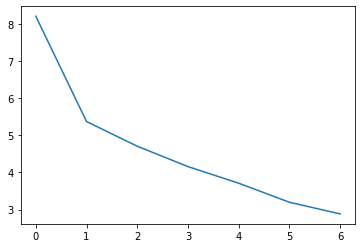

In [175]:
W_KOMP, _ = m._K_OMP(X[:-1], X[1:], normalize = True, F = [])
W_OMP, Ws, MSEs, max_gains = m._OMP_2(X[:-1], X[1:], output = True)
print(f"True W:\n{np.round(A_true, 2)}.")
print(f"Estimated W:\n{np.round(W_KOMP, 2)}.")

plt.plot(MSEs)

X_2 = h.generate_var_2(T, p, A_true, np.identity(p))
print(h.MSE(W_KOMP, X_2))
print(h.MSE(A_true, X_2))

## Post Process Methods
### Criterion per edge
#### Regularize Based on Threshold

In [11]:
def reg_coef(W, threshold):
    # create copy
    W_return = W.copy()
    
    # threshold values
    W_return[np.abs(W_return) <= threshold] = 0
    
    # return matrix
    return W_return

print(np.round(reg_coef(W_OMP, 0.3), 2))

[[ 0.    0.    0.    0.  ]
 [ 0.5   0.    0.    0.  ]
 [ 0.46  0.   -0.57  0.  ]
 [ 0.   -0.43 -0.44  0.  ]]


#### Threshold with respect to increase in MSE

In [12]:
def reg_MSE(W, X, threshold, verbose = False):
    
    W_temp = W.copy()
    stop = False
    
    # iteratively remove edges until all edges yield MSE increase greater than threshold
    while len(W_temp[W_temp != 0]) > 0:
        
        MSE_current = h.MSE(W_temp, X)
        MSE_remove = np.inf
        edge_remove = None
        
        for row, col in np.argwhere(W_temp != 0):
            
            # temporarily remove edge
            tmp = W_temp[row][col]
            W_temp[row][col] = 0

            # compute MSE
            MSE_temp = h.MSE(W_temp, X)

            # check if it is the least important edge
            if MSE_temp < MSE_remove:
                MSE_remove = MSE_temp
                edge_to_remove = [row, col]
                
            # checking is done, try new matrix
            W_temp[row][col] = tmp
        
        if verbose: print(f"Removing edge {edge_to_remove} yields the smallest increase in MSE of {np.round(MSE_remove - MSE_current, 1)}.")
        
        # remove least important edge
        if MSE_remove - MSE_current >= threshold:
            if verbose: print(f"Loss in MSE is larger than threshold. We terminate.")
            return W_temp
        
        else:
            
            # remove entry
            row, col = edge_to_remove
            W_temp[row][col] = 0
            
            # update column
            idx = np.nonzero(W_temp[:, col])[0]
            W_temp[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])
    
    print("Empty Graph! All edges were not important enough.")
    return W_temp
    
print(np.round(reg_MSE(W_KOMP, X, 0.1), 1))

NameError: name 'W_KOMP' is not defined

#### Threshold with respect to correlation with residual

In [13]:
def normalize(x): return x / np.linalg.norm(x)

In [14]:
def gain(W, X, i, j):
    
    return np.abs(normalize(X[:-1, i]) @ (X[1:, j] - (X[:-1] @ W)[:, j]))

In [15]:
def reg_OMP(W, X, threshold, verbose = False):
    
    W_temp = W.copy()
    stop = False
    
    # iteratively remove edges until all edges yield MSE increase greater than threshold
    while len(W_temp[W_temp != 0]) > 0:
        
        resid_remove = np.inf
        edge_remove = None
        
        for row, col in np.argwhere(W_temp != 0):
            
            # temporarily remove edge
            tmp = W_temp[row][col]
            W_temp[row][col] = 0

            # compute MSE
            resid_temp = gain(W_temp, X, row, col)

            # check if it is the least important edge
            if resid_temp < resid_remove:
                resid_remove = resid_temp
                edge_to_remove = [row, col]
                
            # checking is done, try new matrix
            W_temp[row][col] = tmp
        
        if verbose: print(f"Removing edge {edge_to_remove} yields the smallest residual correlation of {np.round(resid_remove, 1)}.")
        
        # remove least important edge
        if resid_remove >= threshold:
            if verbose: print(f"Loss in residual correlation is larger than threshold. We terminate.")
            return W_temp
        else:
            # remove entry
            row, col = edge_to_remove
            W_temp[row][col] = 0
            
            # update column
            idx = np.nonzero(W_temp[:, col])[0]
            W_temp[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])

    print("Empty Graph! All edges were not important enough.")
    return W_temp
    
print(np.round(reg_OMP(W_KOMP, X, 0), 2))

NameError: name 'W_KOMP' is not defined

### Criterion on total matrix $W$

#### Maximum number of edges

In [17]:
def reg_edges(Ws, k):
    if k < 1:
        print("Requesting zero or less edges, returning empty graph.")
        return np.zeros(np.shape(Ws[0]))
    elif k + 1 > len(Ws):
        print("More edges request than possible. Returning densest graph.")
        return Ws[-1]
    
    return Ws[k - 1]

np.round(reg_edges(m._OMP_2(X[:-1], X[1:], output = True)[1], 5), 2)

array([[ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.52,  0.  ,  0.  ,  0.  ],
       [ 0.43,  0.  , -0.57,  0.  ],
       [ 0.  , -0.43, -0.44,  0.  ]])

#### Minimum MSE on Training Data

In [18]:
def reg_MSE_full(Ws, X, tol):
    for W in Ws:
        if h.MSE(W, X) <= tol:
            return W
    
    print("No matrix satisfies the constraint! Returning most suitable matrix.")
    return Ws[-1]
    
np.round(reg_MSE_full(m._OMP_2(X[:-1], X[1:], output = True)[1], X, 3.5), 2)

No matrix satisfies the constraint! Returning most suitable matrix.


array([[ 0.17,  0.  ,  0.  ,  0.  ],
       [ 0.5 ,  0.05,  0.  ,  0.  ],
       [ 0.46, -0.09, -0.57,  0.  ],
       [-0.12, -0.43, -0.44,  0.07]])

## Bootstrapping

# Compare all methods

W_true:
MSE on training set:	 9.6
MSE on test set:	 9.9

W_OMP:
MSE on training set:	 8.3
MSE on test set:	 13.1
[[ 0.2   0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.25  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.3   0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.25  0.35  0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.25  0.    0.    0.4   0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.25  0.    0.45  0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.25  0.    0.    0.5   0.    0.    0.  ]
 [ 0.25  0.    0.25  0.   -0.25  0.    0.    0.55  0.    0.  ]
 [ 0.    0.    0.   -0.25  0.    0.    0.   -0.25  0.6   0.  ]
 [ 0.    0.    0.    0.   -0.25  0.   -0.25  0.    0.25  0.65]]
[[[ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  ...
  [ 0.    0.    0.   ...  0.69  0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.  

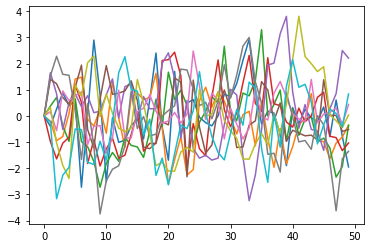

In [149]:
## Generate data
p, s, T = 10, 15, 50
W_true = h.generate_A(p, s, low = 0.25, high = 0.25)

for i in range(p):
    W_true[i][i] = 0.2 + 0.05 * i
    
X = h.generate_var_2(T, p, W_true, np.identity(p))
plt.plot(X)

# Infer matrix using OMP
W_OMP, Ws, MSEs, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

# Generate similar data
X_2 = h.generate_var_2(T, p, W_true, np.identity(p))

## We already see: performs well on training, bad on test
print("W_true:\nMSE on training set:\t", np.round(h.MSE(W_true, X), 1))
print("MSE on test set:\t", np.round(h.MSE(W_true, X_2), 1))

print("\nW_OMP:\nMSE on training set:\t", np.round(h.MSE(W_OMP, X), 1))
print("MSE on test set:\t", np.round(h.MSE(W_OMP, X_2), 1))

# plt.plot(MSEs)

print(W_true)
print(np.round(Ws, 2))

In [150]:
coef_size = 0.3
print(f"Regularize using coefficient size with threshold {coef_size}:\nMSE on training set:\t{np.round(h.MSE(reg_coef(W_OMP, coef_size), X), 1)}.\nMSE on test set:\t{np.round(h.MSE(reg_coef(W_OMP, coef_size), X_2), 1)}.\n")

threshold = 0.5
print(f"Regularize using MSE with threshold {threshold}:\nMSE on training set:\t{np.round(h.MSE(reg_MSE(W_OMP, X, threshold), X), 1)}.\nMSE on test set:\t{np.round(h.MSE(reg_MSE(W_OMP, X, threshold), X_2), 1)}.\n")

threshold = 5
print(f"Regularize using residual correlation, with threshold {threshold}:\nMSE on training set:\t{np.round(h.MSE(reg_OMP(W_OMP, X, threshold), X), 1)}.\nMSE on test set:\t{np.round(h.MSE(reg_OMP(W_OMP, X, threshold), X_2), 1)}.")

Regularize using coefficient size with threshold 0.3:
MSE on training set:	9.6.
MSE on test set:	12.7.

Regularize using MSE with threshold 0.5:
MSE on training set:	11.9.
MSE on test set:	12.2.

Regularize using residual correlation, with threshold 5:
MSE on training set:	11.9.
MSE on test set:	12.2.


### Metric: AUC
We have a threshold that we can vary from zero until infinity. At zero, we simply do not regularization and at infinity, we regularize out all edges. We can calculate the true positive rate (tpr) as a function of this threshold, i.e., how many edges that we detect were actually true after regularizing? Furthermore, we can also compute the false positive rate as a function of this threshold, i.e., how many edges that we detect were actually false after regularizing? This AUC says something important. Clearly, when our threshold is infinity, we detect no edges whatsoever, so our true positive rate is 1, and our false positive rate is 1 by definition.

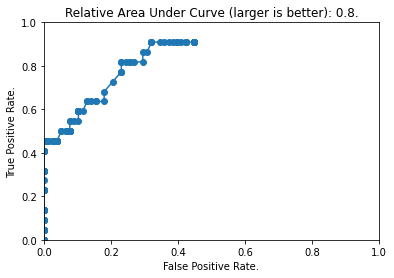

In [151]:
coefs = np.linspace(0, 1, 250)
tprs, fprs = [], []

B_true = (W_true != 0).flatten()

for coef in coefs:
    B_OMP = (reg_coef(W_OMP, coef) != 0).flatten()
    
    tprs.append(((B_OMP == B_true) & (B_OMP == 1)).sum() / (B_true == 1).sum())
    fprs.append(((B_OMP != B_true) & (B_OMP == 1)).sum() / (B_true == 0).sum())

tprs.append(0)
fprs.append(0)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate.")
plt.ylabel("True Positive Rate.")
plt.plot(fprs, tprs, marker = 'o')

plt.title(f"Relative Area Under Curve (larger is better): {round(auc(fprs, tprs) / (max(tprs) * max(fprs)), 2)}.");

0	10	20	30	40	50	60	70	80	90	100	110	120	130	140	150	160	170	180	190	200	210	220	230	240	

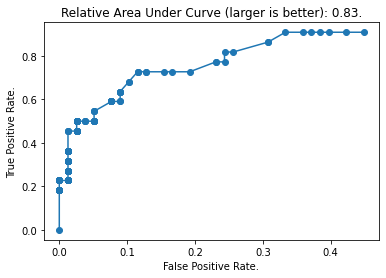

In [152]:
tols = np.linspace(0, 0.5, 250)
tprs, fprs = [], []

B_true = (W_true != 0).flatten()

for i, tol in enumerate(tols):
    if i % 10 == 0: print(i, end = "\t")
        
    B_OMP = (reg_MSE(W_OMP, X, tol) != 0).flatten()

    tprs.append(((B_OMP == B_true) & (B_OMP == 1)).sum() / (B_true == 1).sum())
    fprs.append(((B_OMP != B_true) & (B_OMP == 1)).sum() / (B_true == 0).sum())
    
tprs.append(0)
fprs.append(0)

plt.xlabel("False Positive Rate.")
plt.ylabel("True Positive Rate.")
plt.plot(fprs, tprs, marker = 'o')

plt.title(f"Relative Area Under Curve (larger is better): {round(auc(fprs, tprs) / (max(tprs) * max(fprs)), 2)}.");

0	10	20	30	40	50	60	70	80	90	

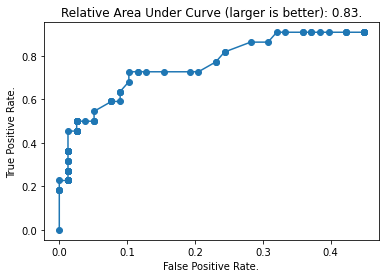

In [158]:
tols = np.linspace(0, 5, 100)
tprs, fprs = [], []

B_true = (W_true != 0).flatten()

for i, tol in enumerate(tols):
    if i % 10 == 0: print(i, end = "\t")
    
    B_OMP = (reg_OMP(W_OMP, X, tol) != 0).flatten()
    
    tprs.append(((B_OMP == B_true) & (B_OMP == 1)).sum() / (B_true == 1).sum())
    fprs.append(((B_OMP != B_true) & (B_OMP == 1)).sum() / (B_true == 0).sum())

tprs.append(0)
fprs.append(0)

plt.xlabel("False Positive Rate.")
plt.ylabel("True Positive Rate.")
plt.plot(fprs, tprs, marker = 'o')

plt.title(f"Relative Area Under Curve (larger is better): {round(auc(fprs, tprs) / (max(tprs) * max(fprs)), 2)}.");

0	No matrix satisfies the constraint! Returning most suitable matrix.
No matrix satisfies the constraint! Returning most suitable matrix.
No matrix satisfies the constraint! Returning most suitable matrix.
No matrix satisfies the constraint! Returning most suitable matrix.
No matrix satisfies the constraint! Returning most suitable matrix.
No matrix satisfies the constraint! Returning most suitable matrix.
No matrix satisfies the constraint! Returning most suitable matrix.
10	20	30	40	50	60	70	80	90	100	110	120	130	140	150	160	170	180	190	200	210	220	230	240	250	260	270	280	290	300	310	320	330	340	350	360	370	380	390	400	410	420	430	440	450	460	470	480	490	

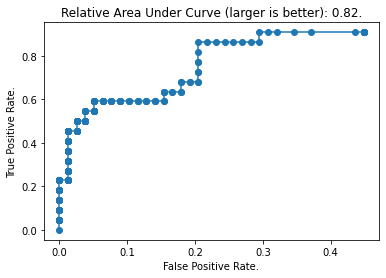

In [157]:
tols = np.linspace(h.MSE(W_OMP, X) - 0.1, h.MSE(np.zeros((p, p)), X) + 0.1, 500)
tprs, fprs = [], []

B_true = (W_true != 0).flatten()

Ws_OMP = m._OMP_2(X[:-1], X[1:], output = True)[1]

for i, tol in enumerate(tols):
    if i % 10 == 0: print(i, end = "\t")
        
    B_OMP = (reg_MSE_full(Ws_OMP, X, tol) != 0).flatten()
    
    tprs.append(((B_OMP == B_true) & (B_OMP == 1)).sum() / (B_true == 1).sum())
    fprs.append(((B_OMP != B_true) & (B_OMP == 1)).sum() / (B_true == 0).sum())

tprs.append(0)
fprs.append(0)

plt.xlabel("False Positive Rate.")
plt.ylabel("True Positive Rate.")
plt.plot(fprs, tprs, marker = 'o')

plt.title(f"Relative Area Under Curve (larger is better): {round(auc(fprs, tprs) / (max(tprs) * max(fprs)), 2)}.");

0	Requesting zero or less edges, returning empty graph.
10	20	30	40	50	More edges request than possible. Returning densest graph.
Relative Area Under Curve (larger is better): 0.82.


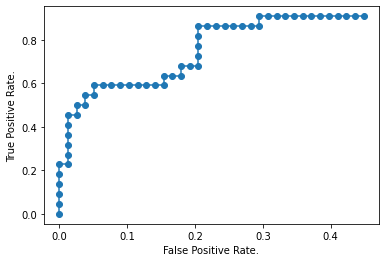

In [159]:
max_edges = range(0, int(p * (p + 1) / 2 + 1))
tprs, fprs = [], []

B_true = (W_true != 0).flatten()
Ws = m._OMP_2(X[:-1], X[1:], output = True)[1]

for edge in max_edges:
    if edge % 10 == 0: print(edge, end = "\t")
  
    B_OMP = (reg_edges(Ws, edge) != 0).flatten()
    
    tprs.append(((B_OMP == B_true) & (B_OMP == 1)).sum() / (B_true == 1).sum())
    fprs.append(((B_OMP != B_true) & (B_OMP == 1)).sum() / (B_true == 0).sum())

plt.xlabel("False Positive Rate.")
plt.ylabel("True Positive Rate.")
plt.plot(fprs, tprs, marker = 'o')

print(f"Relative Area Under Curve (larger is better): {round(auc(fprs, tprs) / (max(tprs) * max(fprs)), 2)}.")

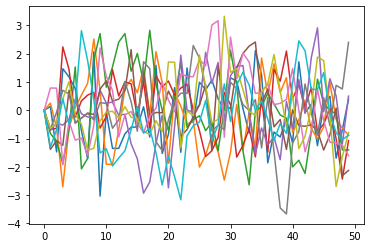

In [128]:
plt.plot(X)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 
Took 174 seconds.


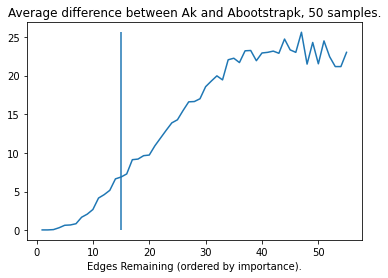

In [160]:
def bootstrap_fast(X, samples = 1):
    W, Ws, mses, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

    diff_bin_avg = []

    for i, W in enumerate(Ws):
        print(i, end = ", ")
        diff_bin = []

        for j in range(samples):
            # generate data according to W
            X_W = h.generate_var_2(T, p, W, np.identity(p))

            # bootstrap, get \hat{W}_k
            bootstrap_W_ii, _, = m._K_OMP(X_W[:-1], X_W[1:], max_coefs = i + 1, normalize = True, F = [])
            
            # difference
            diff_bin.append(np.linalg.norm(((W != 0) ^ (bootstrap_W_ii != 0)).flatten(), 0))

        diff_bin_avg.append(np.sum(diff_bin) / np.shape(diff_bin)[0])

    plt.vlines(s, min(diff_bin_avg), max(diff_bin_avg))
    plt.xlabel("Edges Remaining (ordered by importance).")
    plt.title(f"Average difference between Ak and Abootstrapk, {samples} samples.")
    plt.plot(range(1, len(diff_bin_avg) + 1), diff_bin_avg)
    
    return Ws, diff_bin_avg

start = timer()
Ws, avg = bootstrap_fast(X, samples = 50)
print(f"\nTook {round(timer() - start)} seconds.")

0	10	20	30	40	50	60	70	80	90	100	110	120	130	140	150	160	170	180	190	200	210	220	230	240	250	260	270	280	290	300	310	320	330	340	350	360	370	380	390	400	410	420	430	440	450	460	470	480	490	500	510	520	530	540	550	560	570	580	590	600	610	620	630	640	650	660	670	680	690	700	710	720	730	740	750	760	770	780	790	800	810	820	830	840	850	860	870	880	890	900	910	920	930	940	950	960	970	980	990	

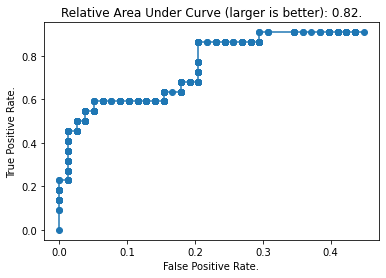

In [161]:
tols = np.linspace(min(avg), max(avg), 1000)
tprs, fprs = [0], [0]

B_true = (W_true != 0).flatten()

for i, tol in enumerate(tols):
    if i % 10 == 0: print(i, end = "\t")
        
    B_OMP = (Ws[np.argmax(np.where(np.array(avg) <= tol))] != 0).flatten()

    tprs.append(((B_OMP == B_true) & (B_OMP == 1)).sum() / (B_true == 1).sum())
    fprs.append(((B_OMP != B_true) & (B_OMP == 1)).sum() / (B_true == 0).sum())

plt.xlabel("False Positive Rate.")
plt.ylabel("True Positive Rate.")
plt.plot(fprs, tprs, marker = 'o')

plt.title(f"Relative Area Under Curve (larger is better): {round(auc(fprs, tprs) / (max(tprs) * max(fprs)), 2)}.");

### Cross Validation - Two Split

Optimal Number of Coefficients: 7.


array([[[ 0.6,  0. ,  0. ],
        [ 0.5, -0.7,  0. ],
        [-0.5,  0.7, -0.6]],

       [[ 0.6,  0. ,  0. ],
        [ 0.5, -0.7,  0. ],
        [-0.5,  0.7, -0.6]]])

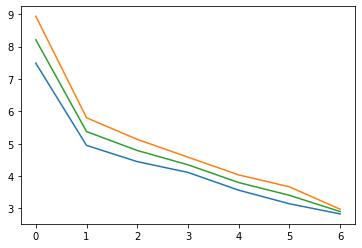

In [176]:
def two_split_var(X):
    T, p = np.shape(X)
    
    # get halves
    X_first = X[:T // 2]
    X_second = X[T // 2:]

    # perform OMP on both halves
    W_first, Ws_first, _, _ = m._OMP_2(X_first[:-1], X_first[1:], output = True)
    W_second, Ws_second, _, _ = m._OMP_2(X_second[:-1], X_second[1:], output = True)

#     print(np.round(W_first, 1))
#     print(np.round(W_second, 1))
    
    # initialize test errors
    mse_cross_val_first = [h.MSE(np.zeros((p, p)), X_second)]
    mse_cross_val_second = [h.MSE(np.zeros((p, p)), X_first)]

    for W_1, W_2 in zip(Ws_first, Ws_second):
        # append test errors
        mse_cross_val_first.append(h.MSE(W_1, X_second))
        mse_cross_val_second.append(h.MSE(W_2, X_first))

    # plot test errors
    plt.plot(mse_cross_val_first)
    plt.plot(mse_cross_val_second)
    
    plt.plot(np.mean(np.vstack((mse_cross_val_first, mse_cross_val_second)), axis = 0))
    
    print(f"Optimal Number of Coefficients: {np.argmin(np.mean(np.vstack((mse_cross_val_first, mse_cross_val_second)), axis = 0)) + 1}.")

    # get cross validated matrices
    W_first = Ws_first[np.argmin(mse_cross_val_first) - 1]
    W_second = Ws_second[np.argmin(mse_cross_val_second) - 1]

    # perform least squares with the common coefficients
    common_coefs = np.bitwise_and((W_second != 0), (W_first != 0))
    
    return constrained_OLS(X, common_coefs), m._K_OMP_output(X[:-1], X[1:], F = [], normalize = True, max_coefs = np.argmin(np.mean(np.vstack((mse_cross_val_first, mse_cross_val_second)), axis = 0)) + 1)[0]

np.round(two_split_var(X), 1)

### Cross - Validation: $k$ Split

In [91]:
def remove(X, k):
    """Remove the timesteps from X that are in the list k"""
    return np.delete(X, k, axis = 0)

np.shape(remove(B, np.array(range(2, 10))))

(100, 10)


(92, 10)

In [244]:
# def k_split_var(X):
#     # train on X_-k,
#     # somehow need to exclude the "gain" from the k timesteps
    
#     # test on X_k
def OMP_k(X, Y, k, max_coefs = int(1e10), tol = 0.0, verbose = False, output = False):
        
    def normalize(X): return X / np.linalg.norm(X, 2)

    # number of variables
    T, n = np.shape(X)

    # intialize F
    F = np.full((n, n), False)
    
    # forbidden indices
    N = set()
    
    # output
    Ws, mses, max_gains = [], [], []
    
    mses.append(1 / T * np.linalg.norm(Y - X @ np.zeros((n, n)), 'f') ** 2)

    # initialize beta
    W = np.zeros((n, n))
    
    # greedy for loop
    for coef in range(min(n ** 2, max_coefs)):
        
        # get the gains
        atoms_del = np.array([normalize(np.delete(X[:, i], k)) for i in range(n)])
        residuals_del = np.array([np.delete((X @ W)[:, j] - Y[:, j], k) for j in range(n)])
        
        print(np.shape(atoms_del), np.shape(residuals_del))
#         print(np.shape(atoms_del[:, k[0]]))
#         print(np.shape(residuals_del[:, k[0]].reshape(1, p)))
#         print(np.shape(atoms_del[:, k[0]].reshape(p, 1) @ np.array(residuals_del[:, k[0]].reshape(p, 1)).T))
#         print(atoms_del[:, k[0]].reshape(p, 1) @ np.array(residuals_del[:, k[0]].reshape(p, 1)).T)
#         print(atoms_del[:, k[0]] @ residuals_del[:, k[0]])

        # remove the index corresponding to the "jump"
#         print(f"Gains2: {np.abs(atoms_del @ residuals_del.T)}.")
#         print(f"Gains: {np.abs(atoms_del @ residuals_del.T - atoms_del[:, k[0]].reshape(p, 1) @ np.array(residuals_del[:, k[0]].reshape(p, 1)).T)}.")
        
        print(np.array([np.abs(normalize(X[:, i]) @ ((X @ W)[:, j] - Y[:, j])) for j in range(n) for i in range(n)]))
        gains = np.abs(atoms_del @ residuals_del.T - atoms_del[:, k[0]].reshape(p, 1) @ np.array(residuals_del[:, k[0]].reshape(p, 1)).T)
        gains = gains.T.flatten()
        
        print(gains)
        # set the forbidden coefficients to negative value, so that they will never be chosen
        gains[list(N)] = -np.ones(len(list(N)))
        
        # find the index that maximizes the gains
        i_max = np.argmax(gains)

        # check if the gain is large enough
        if max(gains) <= tol: break
        
        # add index to F
        F[i_max % n][i_max // n] = True
        
        # get 2D indices based on flattened index i_max
        row, col = i_max % n, i_max // n
        
        # check if we still have a DAG
        if h.is_dag(F):   
            # if so, calculate new betas using only atoms in F
            X_F = X[:, F[:, col]]
            W[F[:, col], col] = np.linalg.inv(X_F.T @ X_F) @ X_F.T @ Y[:, col]
            
            # append to iterative list of W
            Ws.append(W.copy().reshape(n, n))
            
            # append max_gains
            max_gains.append(max(gains))
            
            # check the current mean squared error    
            mses.append(1 / T * np.linalg.norm(Y - X @ Ws[-1], 'f') ** 2)
        else:
            # if we do not have a DAG, we remove it, and add it to the forbidden list
            F[row][col] = False
            N.add(i_max)
        
        # print for feedback
        if verbose:
            print(f"MaxGain: {np.round(max(gains), 2)}.")
            print(f"Gain: {np.round(gains, 2)}.")
            print(f"W:\n{np.round(W, 2)}.\n")
            print(f"F: {F}.")
        
    # return W and extra infor if we care about it
    if output:
        return W.reshape(n, n), Ws, mses, max_gains
    
    # if we do not care about output, we only return betas
    return W

print(np.round(OMP_k(X[:-1], X[1:], range(5, 10)), 1))
print(A_true)
# print(np.round(OMP_k(X[:-1], X[1:], range(T // 2, T - 1)), 1))

(3, 994) (3, 994)
[ 5.67681561 25.7819187  24.5048715  29.73133694 53.23713452 42.50272348
  6.30049579  8.47878072 21.14253926]
[ 5.59156876 25.78113455 24.46318926 29.66994526 53.01000007 42.18412198
  6.20513938  8.26896287 20.9264269 ]
(3, 994) (3, 994)
[5.67681561e+00 2.57819187e+01 2.45048715e+01 1.71094507e+00
 1.63820110e-14 2.15264333e+01 6.30049579e+00 8.47878072e+00
 2.11425393e+01]
[5.59156876e+00 2.57811345e+01 2.44631893e+01 1.75034291e+00
 7.67593695e-03 2.14659596e+01 6.20513938e+00 8.26896287e+00
 2.09264269e+01]
(3, 994) (3, 994)
[1.92466569e+01 1.31558315e-14 1.43463794e+01 1.71094507e+00
 1.63820110e-14 2.15264333e+01 6.30049579e+00 8.47878072e+00
 2.11425393e+01]
[1.91125992e+01 1.12930869e-01 1.44297045e+01 1.75034291e+00
 7.67593695e-03 2.14659596e+01 6.20513938e+00 8.26896287e+00
 2.09264269e+01]
(3, 994) (3, 994)
[1.92466569e+01 1.31558315e-14 1.43463794e+01 8.66339608e-02
 9.51346187e-15 1.17065220e-14 6.30049579e+00 8.47878072e+00
 2.11425393e+01]
[1.91125992

In [100]:
def constrained_OLS(X, coefs):
    """Perform OLS using only the coefficients in coefs"""
    
    T, p = np.shape(X)
    W = np.zeros((p, p))
    
    for i in range(p):
        idx = np.nonzero(coefs[:, i])[0]
        X_idx = X[:-1, idx]
        
        W[idx, i] = np.linalg.inv(X_idx.T @ X_idx) @ X_idx.T @ X[1:, i]
    
    return W

W_true: 10 edges. 
MSE on training set:	 4.9.
MSE on test set:	 4.8

W_OMP: 15 edges. 
MSE on training set:	 4.7
MSE on test set:	 4.8

W_OMP_CV: 10 edges. 
MSE on training set:	 4.7
MSE on test set:	 4.8


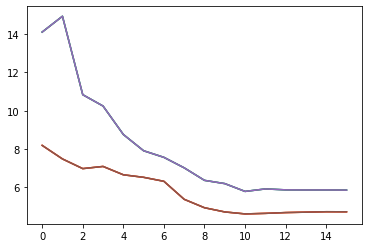

In [59]:
T = 100

# Generate similar data
X = h.generate_var_2(T, p, W_true, np.identity(p))
X_2 = h.generate_var_2(T, p, W_true, np.identity(p))

# Infer matrix using OMP
W_OMP, Ws, MSEs, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

## We already see: performs well on training, bad on test
print(f"W_true: {len(np.nonzero(W_true)[0])} edges. \nMSE on training set:\t {np.round(h.MSE(W_true, X), 1)}.")
print("MSE on test set:\t", np.round(h.MSE(W_true, X_2), 1))

print(f"\nW_OMP: {len(np.nonzero(W_OMP)[0])} edges. \nMSE on training set:\t {np.round(h.MSE(W_OMP, X), 1)}")
print("MSE on test set:\t", np.round(h.MSE(W_OMP, X_2), 1))

print(f"\nW_OMP_CV: {len(np.nonzero(two_split_var(X))[0])} edges. \nMSE on training set:\t {np.round(h.MSE(two_split_var(X), X), 1)}")
print("MSE on test set:\t", np.round(h.MSE(two_split_var(X), X_2), 1))

### Bootstrapping

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 

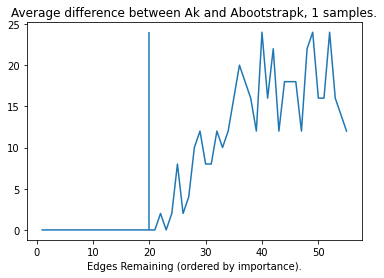

In [75]:
def bootstrap(X, samples = 5):
    W, Ws, mses, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

    diff_bin_avg = []

    for i, W in enumerate(Ws):
        print(i, end = ", ")
        diff_bin = []

        for j in range(samples):
            # generate data according to W
            X_W = h.generate_var_2(T, p, W, np.identity(p))

            # bootstrap, get \hat{W}_k
            _, bootstrap_Ws_i, _, _ = m._OMP_2(X_W[:-1], X_W[1:], output = True)
            bootstrap_W_ii = bootstrap_Ws_i[i]

            # difference
            diff_bin.append(np.linalg.norm(((W != 0) ^ (bootstrap_W_ii != 0)).flatten(), 0))

        diff_bin_avg.append(np.sum(diff_bin) / np.shape(diff_bin)[0])

    plt.vlines(s, min(diff_bin_avg), max(diff_bin_avg))
    plt.xlabel("Edges Remaining (ordered by importance).")
    plt.title(f"Average difference between Ak and Abootstrapk, {samples} samples.")
    plt.plot(range(1, len(diff_bin_avg) + 1), diff_bin_avg)
    
    return Ws, diff_bin_avg

Ws, avg = bootstrap(X, samples = 1)

### Mean Squared Error on Test Data
We simulate $X_{long}$ using the true model, and see how it compares then. We expect that $\texttt{W_true}$ will achieve the smallest MSE, but we hope that a regularized $\texttt{W_OMP}$ will also do well.

In [114]:
X_long = h.generate_var_2(5000, p, W_true, np.identity(p))
print(f"W_OMP:\t{np.round(h.MSE(W_OMP, X_long), 1)}.")
print(f"W_true:\t{np.round(h.MSE(W_true, X_long), 1)}.")

W_OMP:	17.8.
W_true:	14.9.


#### Mean Squared Error in Population Setting
Instead of simualating the data, we can also verify what the expected cost will be of a VAR(1) model. The optimum is achieved for only one specific matrix, the minimizer is unique and is equal to $\texttt{W_true}$. Therefore, we can also regard this as a minimization problem of $\mathbb{E}(\texttt{MSE}(W)) - \mathbb{E}(\texttt{MSE}(\texttt{W_true}))$, or getting this quantity as close to zero as possible.

$$\mathbb{E}\left[\left\lVert X_t - X_{t - 1}W_{est}\right\rVert_2^2\right] = \text{Tr}\left(\left(W_{true} - W_{est}\right)\Sigma_X\left(W_{true} - W_{est}\right)^T\right).$$

In [115]:
def expected_cost(W_true, W_est, Sigma = np.identity(p)):
    
    # base on the distribution of X, no actual data needed.    
    covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W_true, W_true)), Sigma.reshape(p ** 2)).reshape((p, p))
    
    covariance_matrix = Sigma + np.matmul((W_true - W_est), np.matmul(covariance_X, (W_true - W_est).transpose()))
    
    return np.trace(covariance_matrix)

print(f"Difference in MSE between W_OMP and W_true in population setting: {np.round(expected_cost(W_true, W_OMP, np.identity(p)) - expected_cost(W_true, W_true, np.identity(p)), 1)}.")

Difference in MSE between W_OMP and W_true in population setting: 2.7.


W_true: 39 edges. 
MSE on training set:	 15.1.
MSE on test set:	 15.6

W_OMP: 120 edges. 
MSE on training set:	 13.6
Difference in MSE between W_OMP and W_true in population setting: 3.5.
[[ 0.4  0.1  0.   0.5  0.   0.2 -0.3 -0.3  0.  -0.4 -0.2  0.3  0.   0.
   0.2]
 [ 0.   0.1 -0.1 -0.3  0.   0.   0.   0.   0.2  0.   0.   0.   0.   0.
  -0.2]
 [ 0.   0.  -0.1 -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. ]
 [ 0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. ]
 [ 0.1 -0.1  0.3  0.2  0.1  0.2 -0.2  0.5  0.2 -0.2 -0.2  0.3  0.  -0.4
   0.3]
 [ 0.   0.2 -0.2 -0.1  0.   0.6 -0.  -0.   0.   0.1 -0.2 -0.2  0.   0.
   0.4]
 [ 0.   0.6  0.  -0.2  0.   0.   0.3  0.  -0.1  0.   0.   0.1  0.   0.
  -0.1]
 [ 0.  -0.5 -0.  -0.3  0.   0.   0.3  0.4 -0.   0.   0.  -0.2  0.   0.
  -0.1]
 [ 0.   0.  -0.5  0.   0.   0.   0.   0.   0.7  0.   0.   0.   0.   0.
   0. ]
 [ 0.   0.2  0.2  0.2  0.   0.  -0.1  0.3 -0.1  0.7 -0.1  0.1  0.   0.
   0. ]
 [ 0.   0.  -0.5 -0. 

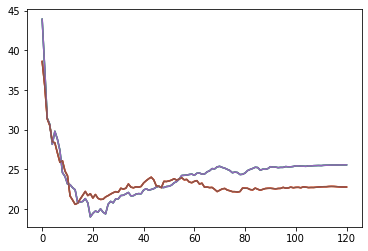

In [116]:
T = 100

# Generate similar data
X = h.generate_var_2(T, p, W_true, np.identity(p))
X_2 = h.generate_var_2(T, p, W_true, np.identity(p))

# Infer matrix using OMP
W_OMP, Ws, MSEs, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

## We already see: performs well on training, bad on test
print(f"W_true: {len(np.nonzero(W_true)[0])} edges. \nMSE on training set:\t {np.round(h.MSE(W_true, X), 1)}.")
print("MSE on test set:\t", np.round(h.MSE(W_true, X_2), 1))

print(f"\nW_OMP: {len(np.nonzero(W_OMP)[0])} edges. \nMSE on training set:\t {np.round(h.MSE(W_OMP, X), 1)}")
print(f"Difference in MSE between W_OMP and W_true in population setting: {np.round(expected_cost(W_true, W_OMP, np.identity(p)) - expected_cost(W_true, W_true, np.identity(p)), 1)}.")

print(f"\nW_OMP_CV: {len(np.nonzero(two_split_var(X))[0])} edges. \nMSE on training set:\t {np.round(h.MSE(two_split_var(X), X), 1)}")
print(f"Difference in MSE between W_OMP and W_true in population setting: {np.round(expected_cost(W_true, two_split_var(X), np.identity(p)) - expected_cost(W_true, W_true, np.identity(p)), 1)}.")